# Tarea 2, pregunta 3: "Encoder-Decoder sobre Texto"

## Integrantes

* _**Francisco Olivares - 201473575-8 - fracisco.olivars.14@sansano.usm.cl**_
* _**Felipe Vega - 201473511-1 - felipe.vega.14@sansano.usm.cl**_

In [16]:
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Tensorflow GPU stuff :v
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

# Modificar estilos de jupyter
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.text_cell_render p, .text_cell_render li { font-size: 12.5pt !important; }</style>"))
display(HTML("<style>.text_cell_render li { margin: 0 0 10px 0; }</style>"))

# Tamaño fuente matplotlib
font = {'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

In [2]:
# Se importa el dataset
import pandas as pd
df = pd.read_csv("dataset_3/spa.txt", sep="\t", names=["Source","Target"])
display(df.head())
df.shape

,Source,Target
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


(123376, 2)

## a)
Visualice los datos ¿Qué es la entrada y qué es la salida? Comente sobre los múltiples significados/sinónimos que puede tener una palabra al ser traducida y cómo propondría arreglar eso. *se espera que pueda implementarlo*

In [3]:
display(df.tail())

,Source,Target
123371,There are mothers and fathers who will lie awa...,Hay madres y padres que se quedan despiertos d...
123372,A carbon footprint is the amount of carbon dio...,Una huella de carbono es la cantidad de contam...
123373,Since there are usually multiple websites on a...,Como suele haber varias páginas web sobre cual...
123374,"If you want to sound like a native speaker, yo...","Si quieres sonar como un hablante nativo, debe..."
123375,It may be impossible to get a completely error...,Puede que sea imposible obtener un corpus comp...


La entrada es una sentencia en ingles, esta puede tener 1 o más palabras. La salida es la sentencia en español la cual puede tener más o menos palabras que la sentencia de entrada.

Una palabra en ingles puede ser traducida de varias maneras al español dado que según el contexto puede cambiar la traducción.

No se realizó ningun arreglo debido a que no se encontró evidencia de que el multiple significado de una palabra tenga incidencia en el desempeño de máquinas entrenadas con una capa de embedding. (Se vió proyectos de ingles a frances [[1]](#Referencias) y de ingles a hindú [[2]](#Referencias))

## b)
Realice un pre-procesamiento a los textos como se acostumbra para eliminar símbolos inecesarios u otras cosas que estime conveniente, comente sobre la importancia de éste paso. Además de ésto deberá agregar un símbolo al final de la sentencia *target* para indicar un "alto" cuando la red neuronal necesite aprender a generar una sentencia.

In [4]:
import string
table = str.maketrans('', '', string.punctuation) 
def clean_text(text, where=None):
    """ OJO: Sin eliminar el significado de las palabras."""
    text = text.lower()
    tokenize_text = text.split()
    tokenize_text = [word.translate(table) for word in tokenize_text]#eliminar puntuacion
    tokenize_text = [word for word in tokenize_text if word.isalpha()] #remove numbers
    if where =="target":
        tokenize_text = tokenize_text + ["#end"] 
    return tokenize_text
texts_input = list(df['Source'].apply(clean_text))
texts_output = list(df['Target'].apply(clean_text, where='target'))

In [5]:
from sklearn.model_selection import train_test_split
X_train_l, X_test_l, Y_train_l, Y_test_l = train_test_split(texts_input, texts_output,
                                                            test_size=10000, random_state=22)

# Se van a seleccionar 35000 elementos
idx = np.random.choice(np.arange(len(X_train_l)), 25000, replace=False)
X_train_l = np.asarray(X_train_l)[idx]
Y_train_l = np.asarray(Y_train_l)[idx]

X_train_l, X_val_l, Y_train_l, Y_val_l = train_test_split(X_train_l, Y_train_l, 
                                                          test_size=10000, random_state=22)

Es necesario estandarizar y limpiar el texto de entrada para así en un paso posterior obtener el vocabulario sobre el cual se está trabajando. Por ejemplo la palabra 'Casa' y 'casa' son distintas a ojos del la red debido a que se diferencian en la mayúscula, entonces se estandariza el texto pasandolo todo a minúscula.

Con ello se intenta obtener un vocabulario reducido ya que tener 2 palabras que aportan la misma información ocupando dos entradas en la tabla de vocabulario no es bueno, sólo añade complejidad. 

## c)
Genere un vocabulario, **desde el conjunto de entrenamiento**, sobre las palabras a recibir y generar en la traducción, esto es codificarlas a un valor entero que servirá para que la red las vea en una representación útil a procesar, *comience desde el 1 debido a que el cero será utilizado más adelante*. Para reducir el vocabulario considere las palabras que aparecen un mínimo de *min_count* veces en todo los datos, se aconseja un valor de 3. Comente sobre la importancia de ésto al reducir el vocabulario ¿De qué tamaño es el vocabulario de entrada y salida? ¿La diferencia de ésto podría ser un factor importante?

In [6]:
def create_vocab(texts, min_count=1):
    count_vocab = {}
    for sentence in texts:
        for word in sentence:
            if word not in count_vocab:
                count_vocab[word] = 1
            else:
                count_vocab[word] += 1
    return [word for word,count in count_vocab.items() if count >= min_count]

vocab_source = create_vocab(X_train_l, min_count=3)
word2idx_s = {w: i+1 for i, w in enumerate(vocab_source)} #index (i+1) start from 1,2,3,...
idx2word_s = {i+1: w for i, w in enumerate(vocab_source)}
n_words_s = len(vocab_source)
vocab_target = create_vocab(Y_train_l, min_count=3)
word2idx_t = {w: i+1 for i, w in enumerate(vocab_target)}  #Converting text to numbers
idx2word_t = {i+1 : w for i, w in enumerate(vocab_target)}
n_words_t = len(vocab_target)

In [7]:
print("Vocabulario de entrada:", n_words_s)
print("Vocabulario de salida:", n_words_t)

Vocabulario de entrada: 2412
Vocabulario de salida: 3035


La cantidad de palabras en cada vocabulario es la que se muestra en la casilla superior.

Dependiendo del parámetro min_count se establece la ocurrencia mínima de la palabra para que sea considerada parte del vocabulario. Si se elige un valor de corte más alto se espera que decremente la cantidad de palabras seleccionadas para el vocabulario de entrada y salida.

El tamaño de los vocabularios es importante ya que influyen en la complejidad de la red, por ejemplo si se ocupa una capa de embeddig (en la entrada), por cada palabra nueva en el vocabulario de entrada se añade una entrada en la matriz de embedding, por lo que se añaden n * embedding_dim pesos nuevos (n = cantidad de palabras nuevas, embedding_dim = dimensión de salida del embedding).

Respecto al vocabulario de salida en la capa softmax se añade una nueva neurona por cada nueva palabra, esto añade n * recurrent_units pesos nuevos (n = nuevas palabras en vocabulario de salida, recurrent_units = cantidad de neuronas recurrentes apiladas en la capa recurrente a la cual se conecta la capa softmax )

Ahora codifique las palabras a los números indexados con el vocabulario. Recuerde que si una palabra en los otros conjuntos, o en el mismo de entrenamiento, no aparece en el vocabulario no se podrá generar una codificación, por lo que será **ignorada** ¿Cómo se podría evitar ésto?

In [8]:
""" Source/input data """

def convert_text_to_index(X, Y, vocabulary):
    transformed_data = list()
    for i in range(len(X)):
        words_in_vocabulary = True
        trasnformed_sentence = []
        for word in X[i]:
            if word in vocabulary:
                trasnformed_sentence.append(vocabulary[word])
            else:
                words_in_vocabulary = False
                break
        if words_in_vocabulary:
            transformed_data.append(trasnformed_sentence)
            
    return transformed_data
            
dataX_train = [[word2idx_s[word] for word in sent if word in word2idx_s] for sent in X_train_l]
dataX_val = [[word2idx_s[word] for word in sent if word in word2idx_s] for sent in X_val_l]
dataX_test = [[word2idx_s[word] for word in sent if word in word2idx_s] for sent in X_test_l]

# dataX_train = convert_text_to_index(X_train_l, word2idx_s)
# dataX_valid = convert_text_to_index(X_val_l, word2idx_s)
# dataX_test = convert_text_to_index(X_test_l, word2idx_s)

""" Target/output data """
dataY_train = [[word2idx_t[word] for word in sent if word in word2idx_t] for sent in Y_train_l]
dataY_val = [[word2idx_t[word] for word in sent if word in word2idx_t] for sent in Y_val_l] 
dataY_test = [[word2idx_t[word] for word in sent if word in word2idx_t] for sent in Y_test_l] 

Se podría evitar generando el vocabulario a partir de TODO el dataset antes de particionarlo en los distintos conjuntos de entrenamiento, validación y testing. Así se debería disminuir la posibilidad de que una palabra no se encuentre presente en el vocabulario. Otra cosa que se podría hacer es disminuir la cantidad mínima de ocurrencias de una palabra para que esta sea conciderada en el vocabulario, actualmente está puesto en 3.

## d)
Debido al largo variable de los textos de entrada y salida será necesario estandarizar ésto para poder trabajar de manera más cómoda en Keras, *cada texto (entrada y salida) pueden tener distinto largo máximo*. Comente sobre la decisión del tipo de *padding*, *pre o post* ¿Qué sucede al variar el largo máximo de instantes de tiempo para procesar en cada parte del modelo (entrada y salida)?

In [9]:
from keras.preprocessing import sequence
""" INPUT DATA (Origin language) """
max_inp_length = max(map(len, dataX_train)) # Se saca el largo de la sentencia más larga
print("Largo max inp: ", max_inp_length)
word2idx_s["PAD"] = 0 #padding symbol
idx2word_s[0] = "PAD"
n_words_s += 1  

# Se procede a aplicar el padding
X_train = sequence.pad_sequences(dataX_train, maxlen=max_inp_length, padding='pre', value=word2idx_s["PAD"])
X_val = sequence.pad_sequences(dataX_val, maxlen=max_inp_length, padding='pre', value=word2idx_s["PAD"])
X_test = sequence.pad_sequences(dataX_test, maxlen=max_inp_length, padding='pre', value=word2idx_s["PAD"])

""" OUTPUT DATA (Destination language) """
max_out_length = max(map(len,dataY_train)) 
print("Largo max out: ",max_out_length)
word2idx_t["PAD"] = 0 #padding symbol
idx2word_t[0] = "PAD"
n_words_t += 1  
Y_train = sequence.pad_sequences(dataY_train, maxlen=max_out_length, padding='post', value=word2idx_t["PAD"])
Y_val = sequence.pad_sequences(dataY_val, maxlen=max_out_length, padding='post', value=word2idx_t["PAD"])
Y_test = sequence.pad_sequences(dataY_test, maxlen=max_out_length, padding='post', value=word2idx_t["PAD"])

Largo max inp:  43


Using TensorFlow backend.


Largo max out:  45


En el caso de la entrada se debiese poder ocupar pre padding o post padding, no debiese haber diferencia. Para el caso de la salida hace sentido que sea post padding ya que la salida a predecir es de largo variable, entonces se hace más natural que cuando la red termine de predecir en caso de que ya haya llegado a un '#end' rellene con post padding.

Al aumentar las dimensiones de la entrada y salida a la sentencia máxima se permite que la red pueda procesar los input de largo variable, ya que ahora a nivel de programación el input y output tienen largo dijo, pero semánticamente no gracias al padding.

## e)
Para evitar que la red obtenga una ganancia por imitar/predecir el símbolo de *padding* que está bastante presente en los datos coloque un peso sobre éste clase, con valor 0, así se evita que tenga impacto en la función objetivo. Ya que *keras* no soporta directamente ésto en series de tiempo coloque el peso a cada instante de tiempo de cada dato de entrenamiento dependiendo de su clase. Comente sobre alguna otra forma en que se podría manejar el evitar que la red prediga en mayoría el símbolo de *padding*.

In [10]:
c_weights = np.ones(n_words_t)
c_weights[0] = 0 #padding class masked
sample_weight = np.zeros(Y_train.shape)
for i in range(sample_weight.shape[0]):
    sample_weight[i] = c_weights[Y_train[i,:]]

Esto se podría evitar ocupando una función de perdida personalizada la cual no considere el caracter de padding al ser evaluada o que lo premie con menor valor respecto a palabras reales.

## f)
Para lograr la tarea defina una red recurrente del tipo *encoder*-*decoder* como la que se presenta en la siguiente imágen.
<img src="https://chunml.github.io/ChunML.github.io/images/projects/sequence-to-sequence/repeated_vector.png" width="60%" />
En primer lugar defina el *Encoder* que procesara el texto de entrada y retornará un solo vector final, haciendo uso de las capas ya conocidas de *Embedding* para generar un vector denso de palabra y *GRU*, pero en su versión acelerada para GPU.

Luego defina la sección que conecta el largo (*timesteps*) de entrada *vs* el de salida.

Finalmente defina el *Decoder* para generar la secuencia de salida en texto de palabras en otro idioma, a través de la función *softmax* sobre cada instante de tiempo (*timestep*). 

In [11]:
from keras.models import Sequential
from keras.layers import Embedding, CuDNNGRU, TimeDistributed, Dense, Dropout
EMBEDDING_DIM = 100

model_F = Sequential()
model_F.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
model_F.add(CuDNNGRU(64, return_sequences=True))
model_F.add(CuDNNGRU(128, return_sequences=False))

from keras.layers import RepeatVector
model_F.add(RepeatVector(max_out_length)) #conection

# Decoder
model_F.add(CuDNNGRU(128, return_sequences=True))
model_F.add(CuDNNGRU(64, return_sequences=True))
model_F.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model_F.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 43, 100)           241300    
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 43, 64)            31872     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 128)               74496     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 45, 128)           0         
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 45, 128)           99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 45, 64)            37248     
_________________________________________________________________
time

In [12]:
print(max_out_length)
print(Y_train.shape)
print(Y_val.shape)
Y_train = np.expand_dims(Y_train, axis=2)
Y_val = np.expand_dims(Y_val, axis=2)
Y_test = np.expand_dims(Y_test, axis=2)

45
(15000, 45)
(10000, 45)


Entrene la red entre 1 a 5 *epochs*, agregando los pesos definidos sobre cada ejemplo de entrenamiento. Además de utilizar una función de pérdida que evita generar explícitamente los *one hot vector*

In [14]:
model_F.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')
history_F = model_F.fit(X_train, Y_train, epochs=5, batch_size=256,validation_data=(X_val, Y_val), sample_weight = sample_weight, verbose=1)

# model_F.compile(optimizer='adam', loss='categorical_crossentropy')
# history_F = model_F.fit(X_train, Y_train, epochs=3, batch_size=256,validation_data=(X_val, Y_val), verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 15000 samples, validate on 10000 samples
Epoch 1/5
15000/15000 [==============================] - 11s 734us/step - loss: 6.6071 - val_loss: 9.5479
Epoch 2/5
15000/15000 [==============================] - 9s 600us/step - loss: 5.6373 - val_loss: 10.4407
Epoch 3/5
15000/15000 [==============================] - 10s 650us/step - loss: 5.6314 - val_loss: 10.8922
Epoch 4/5
15000/15000 [==============================] - 9s 627us/step - loss: 5.6196 - val_loss: 11.2907
Epoch 5/5
15000/15000 [==============================] - 9s 613us/step - loss: 5.5981 - val_loss: 11.5811


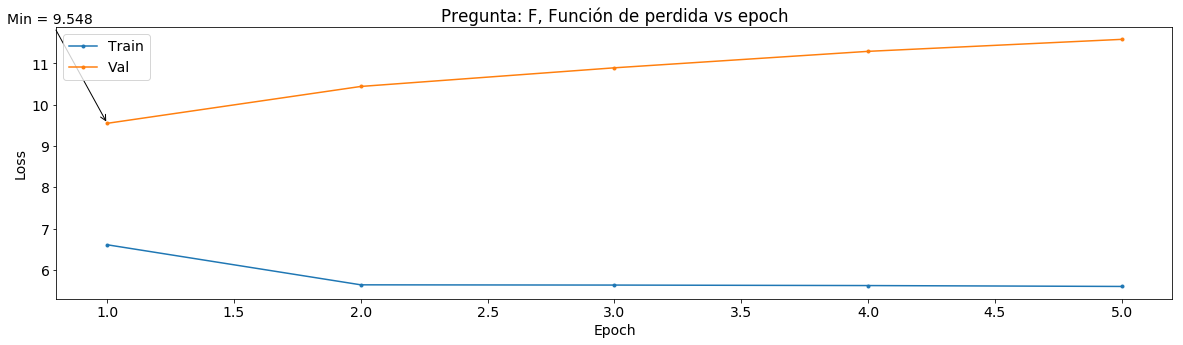

In [21]:
def chart_loss(history, epoch_number, question):
    epoch_arr = [i+1 for i in range(epoch_number)]
    plt.figure(figsize = (20,5))
    plt.plot(epoch_arr, history.history['loss'], '.-')
    plt.plot(epoch_arr, history.history['val_loss'], '.-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend( ('Train', 'Val') )
    plt.title("Pregunta: {}, Función de perdida vs epoch".format(question))

    max_index = np.argmin(history.history['val_loss'])
    max_value = history.history['val_loss'][max_index].round(3)
    plt.annotate('Min = {}'.format(max_value), xy=(max_index+1, max_value), xycoords='data', xytext=(-100, 100), textcoords='offset points', fontsize=14, arrowprops=dict(arrowstyle="->"))


    plt.show()

chart_loss(history_F, 5, "F")

## g)
Debido a lo costoso de tener una red completamente recurrente para entrenar y poder experimentar, cambie el modelo que procesa el *Encoder* por una red convolucional, reduciendo el número de capas pero aumentando las neuronas. Utilice tamaños de *kernel*  igual a 5 y funciones de activaciones relu. Se agregan capas de *BatchNormalization* debido a que en el *Decoder* contamos con redes recurrentes que tienen capa activación distinta a la usada por las convoluciones. La capa de *GlobalMaxPooling1d* es lo que permite reducir toda la información extraída a un único vector, como se realizó anteriormente con *return_sequences=False*, comente sobre la ganancia o desventaja de ésto *vs* la red neuronal.

In [22]:
from keras.layers import Conv1D,MaxPool1D,GlobalMaxPooling1D,GlobalAveragePooling1D,BatchNormalization
model_G = Sequential()
model_G.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
model_G.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
model_G.add(BatchNormalization()) #for stability
model_G.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
model_G.add(BatchNormalization())
model_G.add(GlobalMaxPooling1D()) #aka to return_sequences=False
model_G.add(RepeatVector(max_out_length)) #conection
model_G.add(CuDNNGRU(256, return_sequences=True))
model_G.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model_G.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 43, 100)           241300    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 43, 256)           128256    
_________________________________________________________________
batch_normalization_3 (Batch (None, 43, 256)           1024      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 43, 256)           327936    
_________________________________________________________________
batch_normalization_4 (Batch (None, 43, 256)           1024      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 45, 256)           0         
__________

In [23]:
model_G.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')
history_G = model_G.fit(X_train, Y_train, epochs=20, batch_size=256,validation_data=(X_val, Y_val), sample_weight = sample_weight, verbose=1)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 15s 969us/step - loss: 5.8461 - val_loss: 11.5897
Epoch 2/20
15000/15000 [==============================] - 13s 854us/step - loss: 5.3820 - val_loss: 12.5520
Epoch 3/20
15000/15000 [==============================] - 13s 850us/step - loss: 5.0922 - val_loss: 12.8810
Epoch 4/20
15000/15000 [==============================] - 13s 838us/step - loss: 4.8250 - val_loss: 13.0284
Epoch 5/20
15000/15000 [==============================] - 13s 879us/step - loss: 4.5706 - val_loss: 13.3945
Epoch 6/20
15000/15000 [==============================] - 13s 882us/step - loss: 4.3534 - val_loss: 13.8231
Epoch 7/20
15000/15000 [==============================] - 13s 867us/step - loss: 4.1515 - val_loss: 14.1936
Epoch 8/20
15000/15000 [==============================] - 13s 896us/step - loss: 3.9531 - val_loss: 14.3503
Epoch 9/

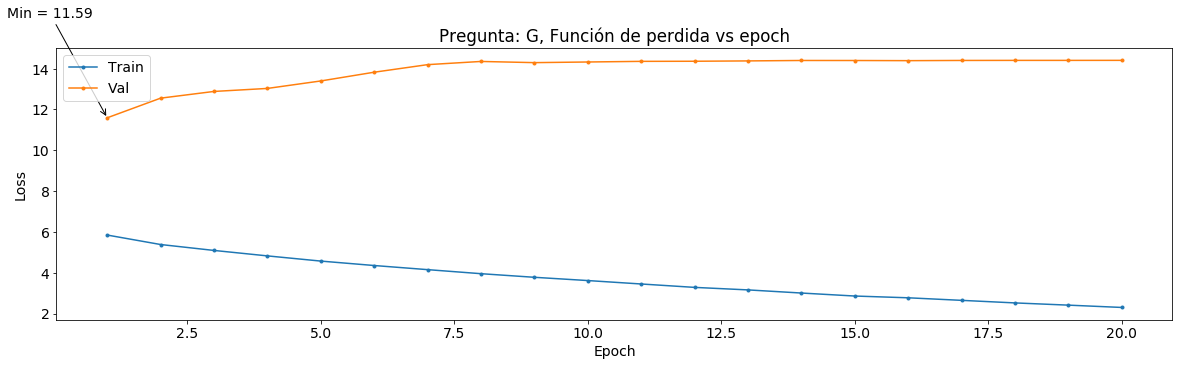

In [24]:
chart_loss(history_G, 20, "G")

Se genera una nueva red la cual tiene más atributos, entonces se espera que esta tenga mayor poder de predicción. Al ver los resultados obtenidos se aprecia que no varian casi nada, pues sigue habiendo un overfitting.

Se aprecia que la red con capa convolucional disminuye el error de entrenamiento más rápido (al ver los resultados en 5 epochs)

## h)
Visualice lo aprendido por el modelo sobre algunos datos del conjunto de entrenamiento y validación, comente lo observado.

In [26]:
def predict_words(y_indexs, data="target"):
    """ Predict until '-#end-' is seen """
    return_val = []
    for indx_word in y_indexs:
        if indx_word != 0: #start to predict
            return_val.append(np.squeeze(indx_word))
            if data == "target": #if target is predicting
                if indx_word == word2idx_t["#end"]:
                    return return_val                
    return return_val

def show_predictions(model, number_of_examples = 5):
    n_s = number_of_examples
    idx = np.random.choice(np.arange(Y_val.shape[0]), size=n_s, replace=False)
    Y_pred = model.predict_classes(X_val[idx] )
    for i, n_sampled in enumerate(idx):
        text_input = [idx2word_s[p] for p in predict_words(X_val[n_sampled], data="source")]
        print("Texto source: ", ' '.join(text_input))
        text_real = [idx2word_t[p] for p in predict_words(Y_val[n_sampled,:,0], data="target")]
        print("Texto target real: ", ' '.join( text_real))
        text_sampled = [idx2word_t[p] for p in predict_words(Y_pred[i], data="target")]
        print("Texto target predicho: ", ' '.join(text_sampled))
        print('\n')
    
show_predictions(model_G)

Texto source:  it was a thing to do
Texto target real:  fue una #end
Texto target predicho:  fue lo para hacer #end


Texto source:  she did her best to help him
Texto target real:  ella hizo todo lo que pudo para #end
Texto target predicho:  ella lo lo que lo #end


Texto source:  he was a
Texto target real:  él estaba una melodía #end
Texto target predicho:  él era era #end


Texto source:  tom eventually
Texto target real:  tom finalmente se #end
Texto target predicho:  tom tom la #end


Texto source:  once a time there was a beautiful
Texto target real:  una vez una hermosa #end
Texto target predicho:  una vez una vez vez #end




Al ver 5 palabras de ejemplo se observa que en la predicción hay duplicados de las palabras :(

## i)
Realice algún cambio esperando que mejore el modelo entrenado, luego vuelva a visualizar lo predicho por la red *vs* lo real. *Debido a lo costoso en entrenar puede optar por realizar solo un cambio pero que sea significativo*.

In [27]:
model_I = Sequential()
model_I.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
model_I.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
model_I.add(BatchNormalization()) #for stability
model_I.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
model_I.add(BatchNormalization())
model_I.add(GlobalMaxPooling1D()) #aka to return_sequences=False
model_I.add(RepeatVector(max_out_length)) #conection
model_I.add(CuDNNGRU(256, return_sequences=True))
model_I.add(Dropout(0.5)) # Se añade Dropout esperando un efecto regularizador
model_I.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model_I.summary() 

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 43, 100)           241300    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 43, 256)           128256    
_________________________________________________________________
batch_normalization_5 (Batch (None, 43, 256)           1024      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 43, 256)           327936    
_________________________________________________________________
batch_normalization_6 (Batch (None, 43, 256)           1024      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 256)               0         
___________________________

In [28]:
model_I.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')
history_I = model_I.fit(X_train, Y_train, epochs=20, batch_size=256,validation_data=(X_val, Y_val), sample_weight = sample_weight, verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 15s 989us/step - loss: 5.9159 - val_loss: 11.5948
Epoch 2/20
15000/15000 [==============================] - 13s 900us/step - loss: 5.4863 - val_loss: 12.3714
Epoch 3/20
15000/15000 [==============================] - 14s 907us/step - loss: 5.3018 - val_loss: 12.3644
Epoch 4/20
15000/15000 [==============================] - 14s 902us/step - loss: 5.1080 - val_loss: 13.1282
Epoch 5/20
15000/15000 [==============================] - 13s 892us/step - loss: 4.9232 - val_loss: 13.7776
Epoch 6/20
15000/15000 [==============================] - 13s 877us/step - loss: 4.7648 - val_loss: 14.2207
Epoch 7/20
15000/15000 [==============================] - 13s 888us/step - loss: 4.6271 - val_loss: 14.3252
Epoch 8/20
15000/15000 [==============================] - 13s 867us/step - loss: 4.4919 - val_loss: 14.3828
Epoch 9/20
15000/15000 [==============================] - 13s 864us/step - loss: 4.368

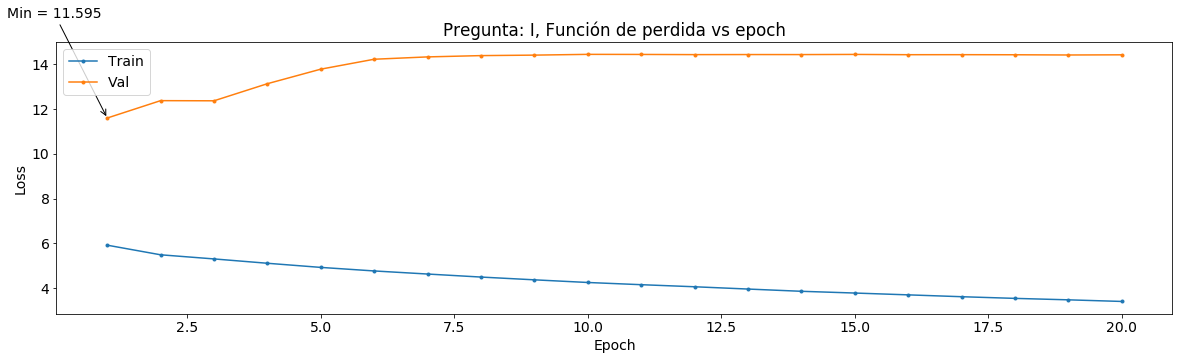

In [31]:
chart_loss(history_I, 20, "I")

In [32]:
show_predictions(model_I)

Texto source:  i want to rest
Texto target real:  quiero descansar #end
Texto target predicho:  quiero #end


Texto source:  we believe in god
Texto target real:  nosotros en dios #end
Texto target predicho:  estamos en en #end


Texto source:  ive been playing soccer since i was fifteen
Texto target real:  he fútbol desde que tenía quince años #end
Texto target predicho:  me estaba estaba que que #end


Texto source:  read as many newspapers as you can so as to keep up with the times
Texto target real:  lee tantos periódicos como puedas para al día #end
Texto target predicho:  el el el el el el el como como como como como como como como como como #end


Texto source:  just then the bus stopped
Texto target real:  justo en ese momento el bus se detuvo #end
Texto target predicho:  la la de de la #end




La modificación realizada fue añadir una capa de Dropout antes de la capa softmax, esto con la esperanza que se detuviera el overfitting. Al ver los resultados se aprecia que aquello no se logra y que los valores de la función de perdida en entrenamiento y validación no sufren mayores cambios

## j)
A pesar de que la tarea de medir qué tan similar es un texto a otro ya es un área de investigación propia [[6]](#refs), usted deberá utilizar alguna métrica de desempeño para ver qué tan buena es la traducción del texto *versus* el texto real entregado. Debido a que la métrica de *Exact Matching* (EM) puede ser muy drástica, mida *f1 score* por texto además de proponer alguna otra técnica de evaluación para medir sobre el conjunto de pruebas y los otros conjuntos si estima conveniente. Puede basarse en otros trabajos como *Image captioning* o *Text summary*. 
*Hint: Debido a los problemas de memoria al realizar un forward-pass, solo seleccione un subconjunto $N_{sub}$ del conjunto de pruebas para realizar ésta evaluación, se aconseja entre 1000 y 5000.*

In [34]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score
m = MultiLabelBinarizer().fit([np.arange(n_words_t)]) 
def calculate_f1(true, pred):
    true = np.squeeze(true)
    pred = np.squeeze(pred)
    binarized_true = m.transform([predict_words(true)])[0] #onehot of words appear
    binarized_pred = m.transform([predict_words(pred)])[0] #onehot of words appear
    return f1_score(binarized_true, binarized_pred, average='binary') #only on appearing words

def get_f1_score(model, X, Y):
    n_s = 1500 # Número de ejemplos para calcular
    idx = np.random.choice(np.arange(Y.shape[0]), size=n_s, replace=False)
    Y_pred = model.predict_classes(X[idx])

    f1_final = np.mean([calculate_f1(true_words,pred_words) for true_words,pred_words in zip(Y[idx],Y_pred)])
    
    return f1_final*100 #porcentaje

print("F1-Score:", get_f1_score(model_I, X_val, Y_val))



F1-Score: 53.01893411484742


## k)
En ves de volver a variar el modelo de *Encoder*, dejaremos una representación manual explícita (*no entrenable*) a través de extraer características manuales de los textos *source*, como por ejemplo representaciones *term frequency* (TF) o TF-IDF, proporcionadas a través de __[sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text)__. Luego, con esto generado, defina y entrene el modelo *Decoder* neuronal como el presentado en las preguntas anteriores, ésto es comenzar desde la capa *RepeatVector* hasta llegar a la clasificación sobre el texto *target*. Compare el desempeño con lo presentado en (j) y lo visualizado en (h).

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
def dummy_fun(doc):
    return doc
tf_idf = TfidfVectorizer(analyzer='word',tokenizer=dummy_fun,preprocessor=dummy_fun,
                         token_pattern=None,use_idf= True, smooth_idf=True, norm='l2') 


train_length = len(dataX_train)

temp = tf_idf.fit_transform(dataX_train+dataX_val).astype('float32').todense()

X_train_tfidf = temp[:train_length,:]
X_val_tfidf = temp[train_length:, :]

In [36]:
print(X_train_tfidf.shape)
print(X_val_tfidf.shape)

(15000, 2412)
(10000, 2412)


In [37]:
print(X_train_tfidf)

[[0.37679997 0.40736797 0.27443227 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [38]:
from keras.layers import InputLayer
model_K = Sequential()

model_K.add(InputLayer(input_shape=(X_train_tfidf.shape[1], )))
model_K.add(RepeatVector(max_out_length)) #conection

model_K.add(CuDNNGRU(256, return_sequences=True))
model_K.add(Dropout(0.25)) # Se añade Dropout esperando un efecto regularizador
model_K.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model_K.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
repeat_vector_5 (RepeatVecto (None, 45, 2412)          0         
_________________________________________________________________
cu_dnngru_8 (CuDNNGRU)       (None, 45, 256)           2050560   
_________________________________________________________________
dropout_2 (Dropout)          (None, 45, 256)           0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 45, 3036)          780252    
Total params: 2,830,812
Trainable params: 2,830,812
Non-trainable params: 0
_________________________________________________________________


In [39]:
model_K.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')
history_k = model_K.fit(X_train_tfidf, Y_train, epochs=20, batch_size=256,validation_data=(X_val_tfidf, Y_val), sample_weight = sample_weight, verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 17s 1ms/step - loss: 6.7452 - val_loss: 14.6926
Epoch 2/20
15000/15000 [==============================] - 16s 1ms/step - loss: 5.9465 - val_loss: 14.6696
Epoch 3/20
15000/15000 [==============================] - 16s 1ms/step - loss: 5.7924 - val_loss: 14.6557
Epoch 4/20
15000/15000 [==============================] - 16s 1ms/step - loss: 5.6520 - val_loss: 14.6334
Epoch 5/20
15000/15000 [==============================] - 16s 1ms/step - loss: 5.4963 - val_loss: 14.6157
Epoch 6/20
15000/15000 [==============================] - 16s 1ms/step - loss: 5.3957 - val_loss: 14.6051
Epoch 7/20
15000/15000 [==============================] - 16s 1ms/step - loss: 5.3053 - val_loss: 14.5918
Epoch 8/20
15000/15000 [==============================] - 17s 1ms/step - loss: 5.1891 - val_loss: 14.5764
Epoch 9/20
15000/15000 [==============================] - 16s 1ms/step - loss: 5.0558 - val_loss: 14.5

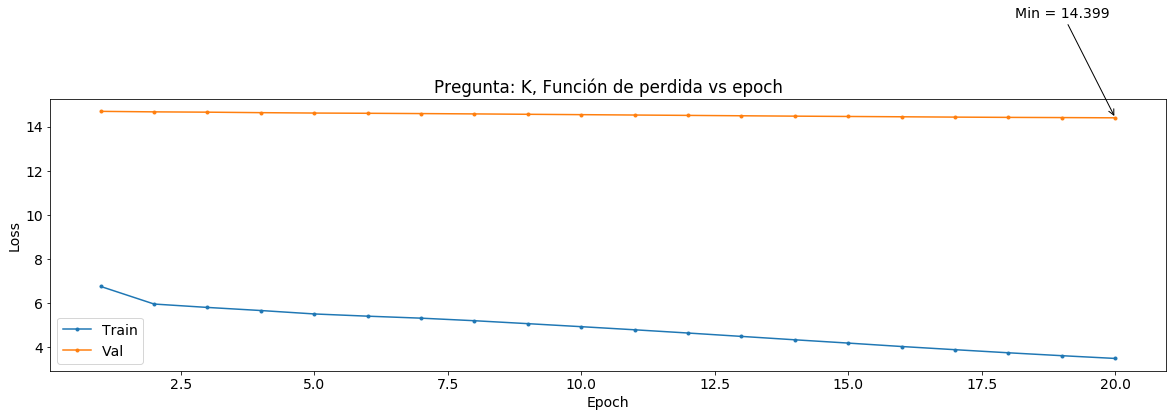

In [40]:
chart_loss(history_k, 20, "K")

In [41]:
def show_predictions_2(model, number_of_examples = 5):
    n_s = number_of_examples
    idx = np.random.choice(np.arange(Y_val.shape[0]), size=n_s, replace=False)
    Y_pred = model.predict_classes(X_val_tfidf[idx] )
    for i, n_sampled in enumerate(idx):
        text_input = [idx2word_s[p] for p in predict_words(X_val[n_sampled], data="source")]
        print("Texto source: ", ' '.join(text_input))
        text_real = [idx2word_t[p] for p in predict_words(Y_val[n_sampled,:,0], data="target")]
        print("Texto target real: ", ' '.join( text_real))
        text_sampled = [idx2word_t[p] for p in predict_words(Y_pred[i], data="target")]
        print("Texto target predicho: ", ' '.join(text_sampled))
        print('\n')
show_predictions_2(model_K)

Texto source:  and deal with the study of life
Texto target real:  la y la sobre el estudio de la vida #end
Texto target predicho:  la la con con con con con #end


Texto source:  the weather says it will be tomorrow
Texto target real:  el del clima dice que estará más helado mañana #end
Texto target predicho:  el que que mañana mañana mañana #end


Texto source:  i was late for school this morning
Texto target real:  esta mañana llegué tarde a la escuela #end
Texto target predicho:  esta mañana esta esta esta mañana tarde #end


Texto source:  im being good to you this morning
Texto target real:  yo estoy siendo bueno contigo esta mañana #end
Texto target predicho:  estoy que esta esta esta esta mañana mañana mañana #end


Texto source:  i hope your wishes will come true
Texto target real:  espero que tus se hagan realidad #end
Texto target predicho:  espero que que que #end




In [42]:
print("F1-Score:", get_f1_score(model_K, X_val_tfidf, Y_val))

F1-Score: 52.88331163447262


Al ver el resultado se aprecia que en esta red también hay presencia de overfitting, pero al menos se ve una tendencia de que el error de validación va disminuyendo muy lentamente.

En terminos del F1-Score no hay gran mejora.

# Referencias
[1] Language Translation with RNNs. (2019). Medium. Retrieved 1 August 2019, from https://towardsdatascience.com/language-translation-with-rnns-d84d43b40571

[2] Engish to Hindi translate using Keras | Kaggle. (2019). Kaggle.com. Retrieved 1 August 2019, from https://www.kaggle.com/harishreddy18/engish-to-hindi-translate-using-keras?fbclid=IwAR1Z9i_bXmNvdLD8C3kcLz7fQZFmDjWpSWw_wp6SskBSnkTZDGS7-ZxRKYY